### Neural Network Development

Rather than learn to predict the optimal charging schedule produced by a heuristic method for a given profile, we could try using a custom loss function that directly reflects the (negative) scoring metric. The score is based on the proportion of solar PV that is used to charge the battery. For a given scheduled charge $y_i$ and solar PV output $\hat{y}_i$, the amount of solar PV exploited is $min(y_i, \hat{y}_i)$. The proportion of maximum solar PV for a given day is:

$$\frac{\min(\mathbf{y}, \hat{\mathbf{y}})}{\min(C, \sum \hat{\mathbf{y}})}$$

However we also have two constraints on the capacity of the battery (which we also want to fill completely) and the max charge rate. First, the sum of our predicted values must equal the battery capacity $C$. We will penalise not meeting this constraint in the loss function:

$$\phi = \alpha (C - \sum{\mathbf{y}})^2 $$

We will apply a similar idea for penalising exceeding the max charge rate: 

$$\gamma = \beta \sum_{i} \max (y_i - B, 0)) $$



We will consider the target value $y$ to be the solar profile and use the following loss function: 

$$L = \frac{\min(\mathbf{y}, \hat{\mathbf{y}})}{\min(C, \sum \hat{\mathbf{y}})} + \phi (\mathbf{y}) + \gamma (\mathbf{y}) $$


#### Data dimensionality

One thing to note here is that we are trying to map to a whole day of charging schedule in one go, whereas previously we have been going point by point. As a result, each observation $(\mathbf{X}, \mathbf{y})$ is a whole day, so we have much less data to work with (doubly bad if we want to use a neural net, which is data hungry). In addition, it leaves us with the problem of how to represent the whole day in the input vector: the state dimensionality quickly becomes very large. 

First we will define the neural network:

In [353]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):

    def __init__(self, n_in, n_out, n_layers, n_nodes):
        super(Net, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.in_layer = nn.Linear(self.n_in, self.n_nodes)
        self.layers = nn.ModuleList([nn.Linear(self.n_nodes, self.n_nodes) for i in range(self.n_layers)])
        self.out_layer = nn.Linear(self.n_nodes, self.n_out)
        self.activation = F.relu
        
    def forward(self, x):
        x = self.in_layer(x)
        x = self.activation(x)
        for l in self.layers:
            x = l(x)
            x = self.activation(x)
        x = self.out_layer(x)
        x = F.relu(x) # can apply relu here as outputs must be above 0 anyway
        
        return x
    
def charging_loss_function(y, y_pred, alpha=1e-3, beta=1e-1, capacity=6, time_unit=0.5, max_charge_rate=2.5):
    
    C = torch.tensor(capacity/time_unit)
    B = torch.tensor(max_charge_rate)
        
    phi = alpha * torch.mean(torch.square(C - y_pred.sum(axis=1)))
    gamma = beta * torch.mean(torch.maximum(y_pred - B, torch.tensor(0)))
            
    L = -(torch.minimum(y, y_pred) / torch.minimum(C, torch.sum(y_pred))) + phi + gamma
    L = torch.mean(L)
        
    return L, phi, gamma

Now we will process the data, taking using the mean of each variable each day. 

**Note: taking the mean for each variable is a terrible idea, but it is convenient for this prototype!**

In [477]:
def construct_NN_training_df(start_time='04:00', end_time='15:00', time_unit=0.5):

    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = construct_df_charge_features(df)
    n_periods = int(1 + (pd.Timestamp('15:00') - pd.Timestamp('04:00')).components.hours / time_unit)

    df_features = df_features.between_time(start_time, end_time)

    dt_idx = pd.date_range(df_features.index.min(), df['pv_power_mw'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')
    s_pv = df['pv_power_mw'].loc[dt_idx]

    # Filter only complete days
    day_counts = s_pv.groupby(s_pv.index.date).count()
    complete_days = pd.DatetimeIndex(day_counts[day_counts==48].index)
    s_pv = s_pv[pd.to_datetime(s_pv.index.date).isin(complete_days)].between_time(start_time, end_time)
    df_features = df_features[pd.to_datetime(df_features.index.date).isin(complete_days)]

    # Take the mean of each variable: NOTE: this is a huge compromise!! 
    df_features_mean = df_features.groupby(df_features.index.date).mean()

    # Standardise
    df_features_norm = df_features_mean.apply(lambda x: (x - np.mean(x))/np.std(x))

    # Arrays of inputs and targes
    inputs = torch.tensor(df_features_norm.values).float()
    targets = torch.tensor(s_pv.values.reshape(len(complete_days), n_periods)).float()
    
    return inputs, targets

def train_test_split(X, Y, split_prop=0.8):
    random_perm = torch.randperm(X.shape[0])
    split_idx = int(X.shape[0] * split_prop)
    train_idx = random_perm[:split_idx]
    test_idx = random_perm[split_idx:]
    
    train_X, train_Y = X[train_idx], Y[train_idx]
    test_X, test_Y = X[test_idx], Y[test_idx]
    
    return train_X, train_Y, test_X, test_Y

def get_batch(train_X, train_Y, size):
    batch_idx = torch.randperm(train_X.shape[0])[:size]
    return train_X[batch_idx], train_Y[batch_idx]


Finally let's run a quick test: 

Text(0.5, 1.0, 'Charge rate penalty')

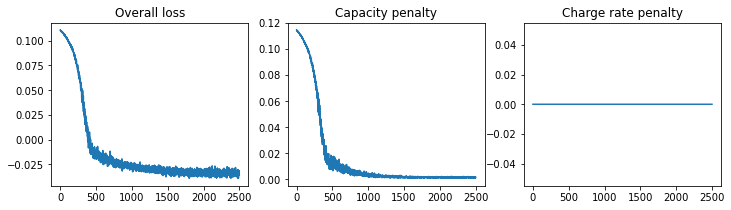

In [479]:
X, Y = construct_NN_training_df()
train_X, train_Y, test_X, test_Y = train_test_split(X, Y, 0.8)

net = Net(inputs.shape[1], targets.shape[1], 3, 16)
optimizer = optim.Adam(net.parameters(), lr=1e-4)
batch_size = 32

losses=[]
phis = []
gammas = []

for i in range(2500):
    
    inputs, targets = get_batch(train_X, train_Y, batch_size)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(inputs)
    loss, phi, gamma = charging_loss_function(targets, output)
    loss.backward()
    optimizer.step()    # Does the update
    
    losses.append(loss.item())
    phis.append(phi.item())
    gammas.append(gamma.item())

fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(losses)
ax[1].plot(phis)
ax[2].plot(gammas)
ax[0].set_title("Overall loss")
ax[1].set_title("Capacity penalty")
ax[2].set_title("Charge rate penalty")

27


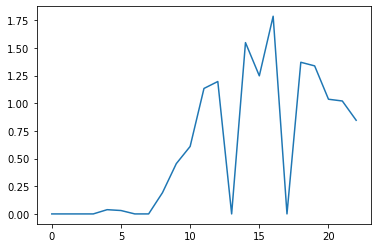

In [480]:
out = net(test_X).detach().numpy()
idx = np.random.randint(out.shape[0])
print(idx)
plt.plot(out[idx])
